# Investigating the impact of moderator interventions

In [48]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

import tasks.stats
import tasks.postprocessing
import tasks.graphs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
sns.set(style="whitegrid")
sns.set(font_scale=1.5)

In [50]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [51]:
full_df = tasks.postprocessing.get_main_dataset()
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",2,4,False
1,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,5,False
2,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
3,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
4,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57470,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57471,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57472,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57473,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False


## When do moderators intervene?

In [52]:
df_unique = full_df[full_df["conv_variant"] != "No Moderator"].drop_duplicates(
    subset=["message_id"]
)

moderator_interventions = (
    df_unique[df_unique["is_moderator"]].groupby("conv_id").size()
)
conv_variants = (
    df_unique[["conv_id", "conv_variant"]]
    .drop_duplicates()
    .set_index("conv_id")
)
intervention_df = moderator_interventions.to_frame(
    name="moderator_interventions"
).join(conv_variants, how="left")

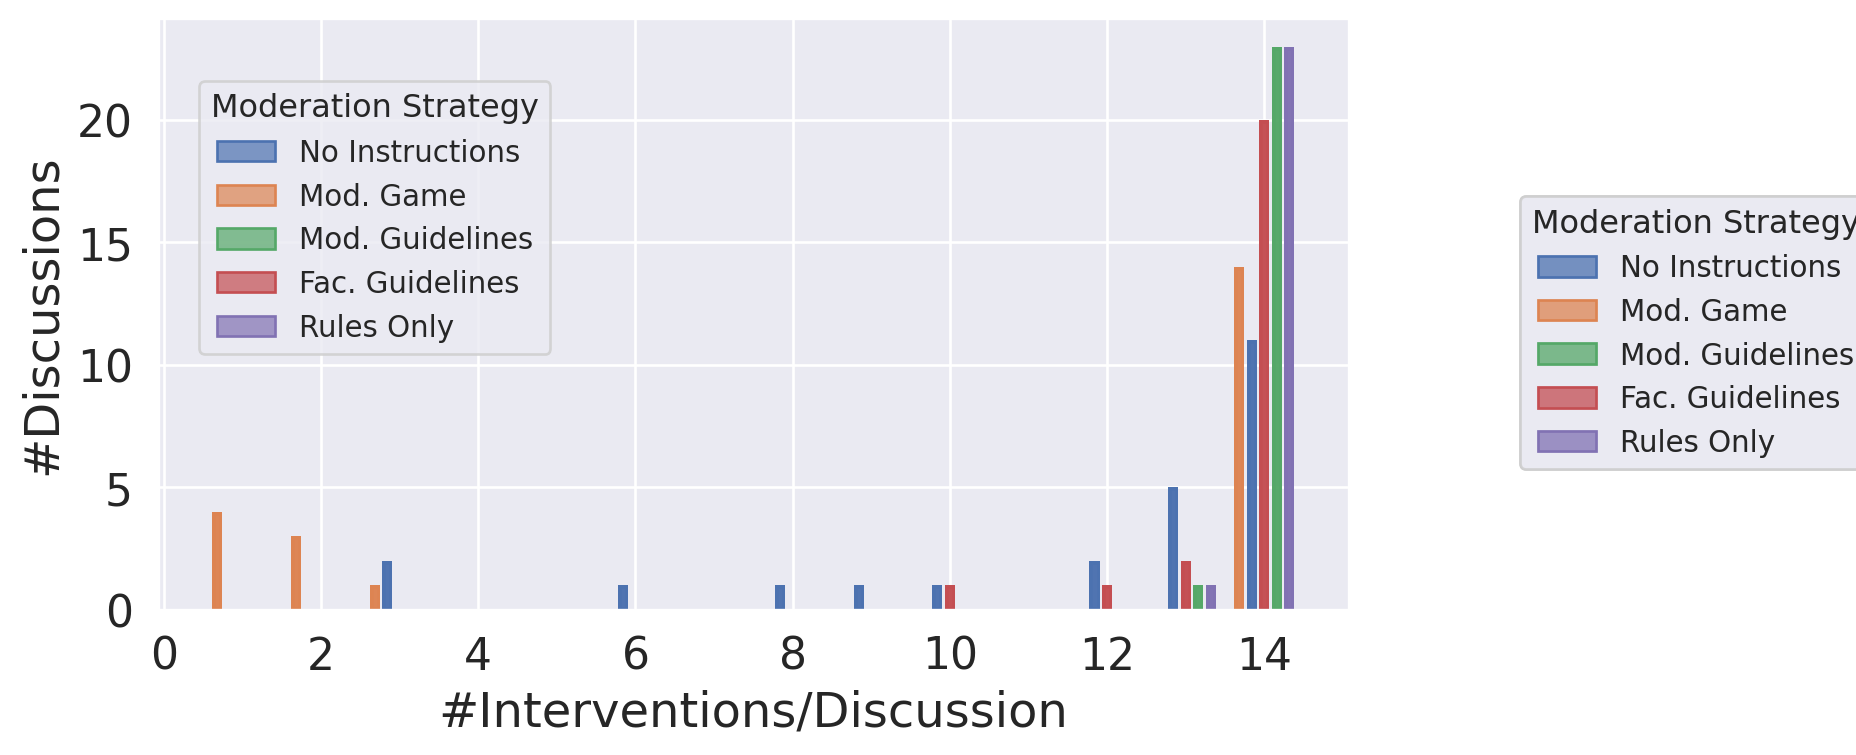

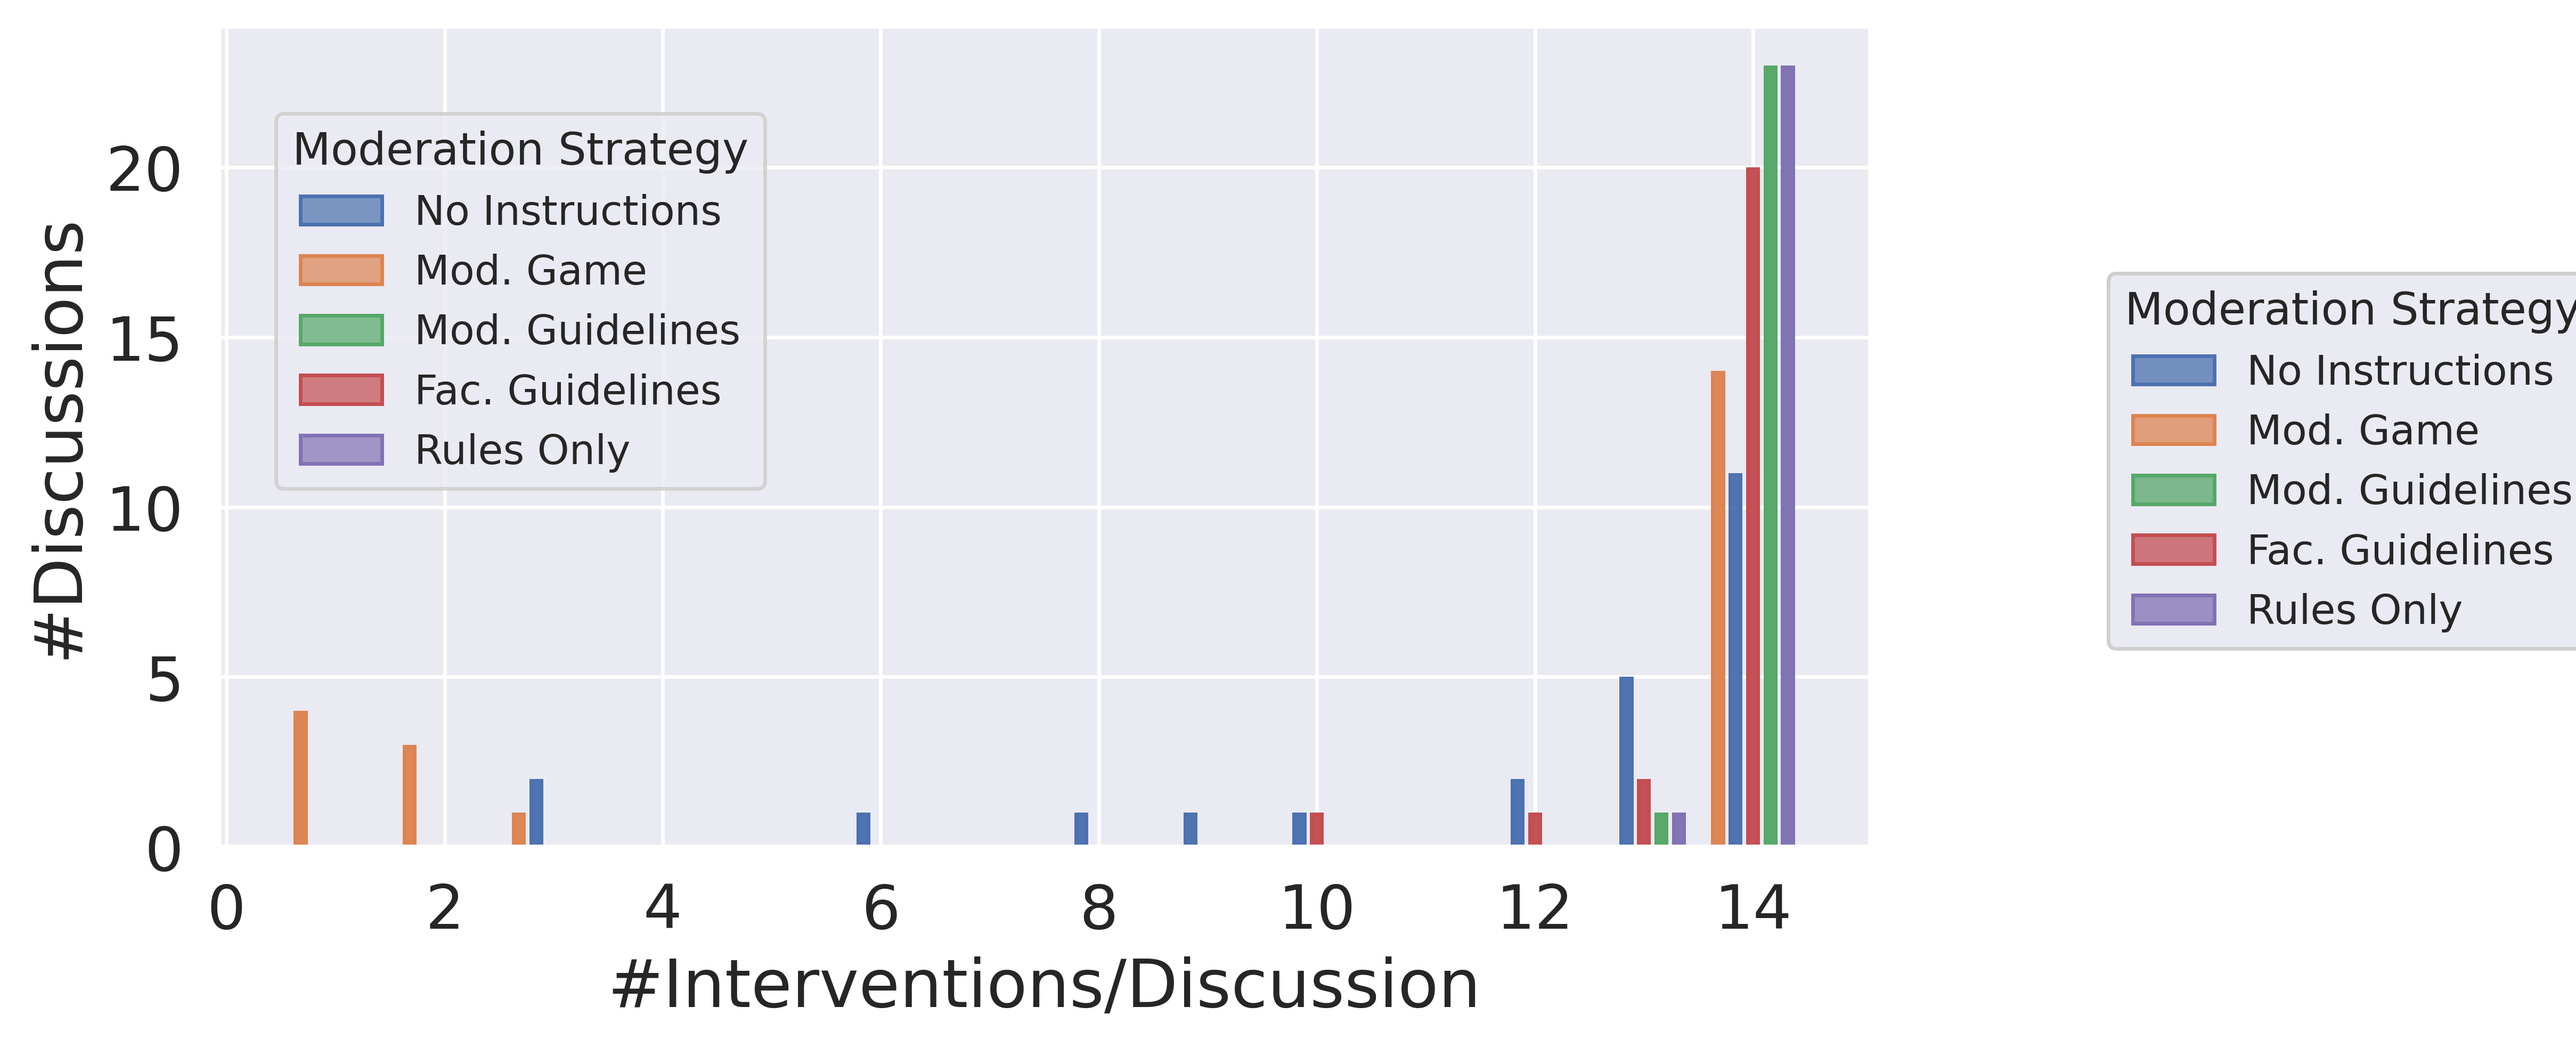

In [62]:
f = plt.figure(figsize=(8, 4))
f.set_dpi(500)
ax = plt.gca()
p = so.Plot(
    data=intervention_df.rename(
        {"conv_variant": "Moderation Strategy"}, axis=1
    ),
    x="moderator_interventions",
    color="Moderation Strategy",
)
p = p.on(ax)
p = p.add(so.Bar(), so.Count(), so.Dodge(gap=0.2))
p = p.label(
        x="#Interventions/Discussion", 
        y="#Discussions",
    )
p.plot()

f.legends[0].set_bbox_to_anchor((0.12, 0.7))
# crop out extra legend
bbox = Bbox([[0, -0.2], [7, 4]])
p.save(GRAPH_OUTPUT_DIR / "intervention_count.png", bbox_inches=bbox)

## Statistical Analysis

In [54]:
analysis_df = full_df.loc[
    (full_df.intent != "Moderator") & (full_df.model != "hardcoded")
]

### Moderation Strategy

#### Toxicity

In [55]:
tasks.stats.mean_comp_test(
    df=analysis_df, feature_col="conv_variant", score_col="Toxicity"
)

8.88378208253797e-199

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/toxicity_stats.png


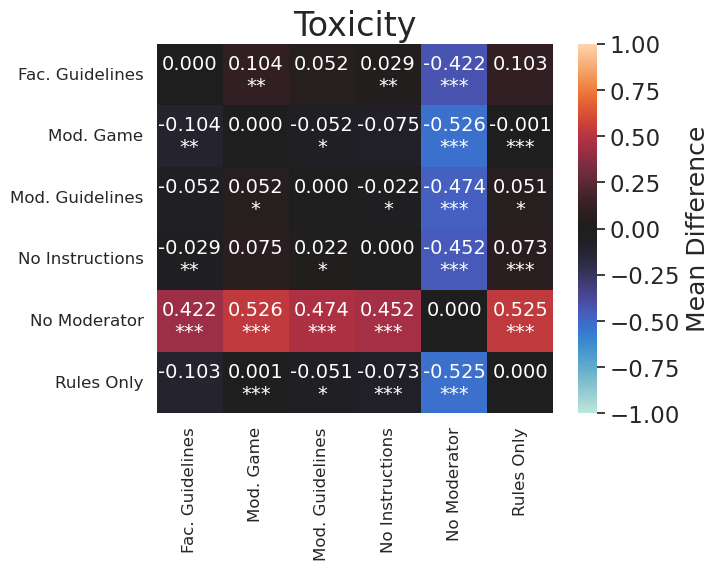

In [56]:
tasks.graphs.posthoc_heatmap(
    analysis_df,
    val_col="Toxicity",
    group_col="conv_variant",
    vmin=VMIN_TOXICITY,
    vmax=VMAX_TOXICITY,
)

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "toxicity_stats.png")
plt.show()

#### Argument Quality

In [57]:
tasks.stats.mean_comp_test(
    df=analysis_df, feature_col="conv_variant", score_col="Argument Quality"
)

4.79135280857012e-46

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/argumentq_stats.png


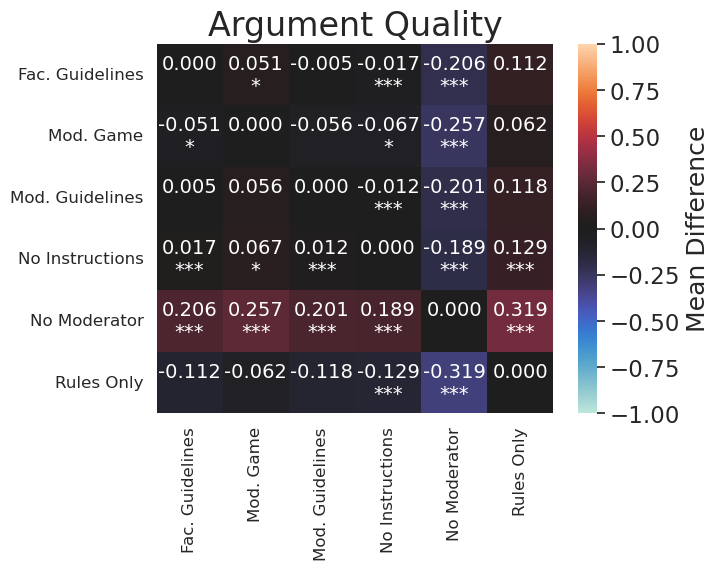

In [58]:
tasks.graphs.posthoc_heatmap(
    analysis_df,
    val_col="Argument Quality",
    group_col="conv_variant",
    vmin=VMIN_TOXICITY,
    vmax=VMAX_TOXICITY,
)

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "argumentq_stats.png")
plt.show()